In [315]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from tensorflow.keras.datasets import fashion_mnist
from tensorflow import keras
from tensorflow.keras.layers import Conv2D, Dense, Activation, Flatten, MaxPooling2D, Dropout

!pip install -U keras-tuner
from kerastuner.tuners import RandomSearch
from kerastuner.engine.hyperparameters import HyperParameters

import time


Requirement already up-to-date: keras-tuner in /usr/local/lib/python3.7/dist-packages (1.0.2)


In [316]:
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()

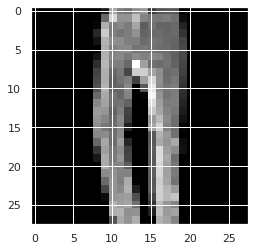

In [317]:
plt.imshow(X_train[np.random.randint(len(X_train))], cmap="gray")
plt.show()

In [318]:
# before reshape
X_train.shape

(60000, 28, 28)

In [319]:
X_train = X_train.reshape(-1,28,28,1)
X_test = X_test.reshape(-1,28,28,1)

In [320]:
# after reshape
X_train.shape

(60000, 28, 28, 1)

In [321]:
# random search passes this hyperparameter() object
def build_model(hp):
  model = keras.models.Sequential()

  model.add(
      Conv2D(
        hp.Int("input_units", min_value=32, max_value=128, step=32),
        (3,3), 
        input_shape=X_train.shape[1:]
      )
    )
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))

  for layer in range(hp.Int("n_layers",1,4)):
    Dropout(
      hp.Float(
        f'dropout_{layer}_units',
        min_value=0.0,
        max_value=0.9,
        default=0,
        step=0.1
      )
    )
    model.add(
      Conv2D(
        hp.Int(f"conv_{layer}_units", min_value=32, max_value=128, step=32),
        (3,3)
      )
    )
    model.add(Activation('relu'))
    # model.add(MaxPooling2D(pool_size=(2, 2)))

  model.add(Flatten())

  model.add(Dense(10))
  model.add(Activation("softmax"))

  model.compile(
    optimizer=keras.optimizers.Adam(
      hp.Choice('learning_rate',values=[1e-2, 1e-3, 1e-4])
    ),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
  )

  return model

In [322]:
# LOG_DIR = f"{int(time.time())}"
LOG_DIR = "fm"

In [323]:
# The Keras Tuner has four tuners available - RandomSearch, Hyperband, BayesianOptimization, and Sklearn
tuner = RandomSearch(
  build_model,
  objective='val_accuracy',
  max_trials=3,
  executions_per_trial=5,
  directory=LOG_DIR,
  project_name='fashion_mnist'
)

tuner.search_space_summary()

INFO:tensorflow:Reloading Oracle from existing project fm/fashion_mnist/oracle.json
INFO:tensorflow:Reloading Tuner from fm/fashion_mnist/tuner0.json
Search space summary
Default search space size: 11
input_units (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 128, 'step': 32, 'sampling': None}
n_layers (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 4, 'step': 1, 'sampling': None}
dropout_0_units (Float)
{'default': 0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.9, 'step': 0.1, 'sampling': None}
conv_0_units (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 128, 'step': 32, 'sampling': None}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}
dropout_1_units (Float)
{'default': 0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.9, 'step': 0.1, 'sampling': None}
conv_1_units (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 128, '

In [324]:
stop_early = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

In [325]:
tuner.search(
  X_train, y_train,
  epochs=10,
  validation_data=(X_test, y_test),
  callbacks=[stop_early]
)

INFO:tensorflow:Oracle triggered exit


In [326]:
tuner.get_best_hyperparameters()[0].values

{'conv_0_units': 64,
 'conv_1_units': 96,
 'conv_2_units': 128,
 'conv_3_units': 64,
 'dropout_0_units': 0.7000000000000001,
 'dropout_1_units': 0.8,
 'dropout_2_units': 0.0,
 'dropout_3_units': 0.2,
 'input_units': 96,
 'learning_rate': 0.0001,
 'n_layers': 4}

In [327]:
tuner.results_summary()

Results summary
Results in fm/fashion_mnist
Showing 10 best trials
Objective(name='val_accuracy', direction='max')
Trial summary
Hyperparameters:
input_units: 96
n_layers: 4
dropout_0_units: 0.7000000000000001
conv_0_units: 64
learning_rate: 0.0001
dropout_1_units: 0.8
conv_1_units: 96
dropout_2_units: 0.0
conv_2_units: 128
dropout_3_units: 0.2
conv_3_units: 64
Score: 0.9088800072669982
Trial summary
Hyperparameters:
input_units: 64
n_layers: 4
dropout_0_units: 0.30000000000000004
conv_0_units: 128
learning_rate: 0.01
dropout_1_units: 0
conv_1_units: 32
dropout_2_units: 0
conv_2_units: 32
dropout_3_units: 0
conv_3_units: 32
Score: 0.7817000031471253
Trial summary
Hyperparameters:
input_units: 32
n_layers: 4
dropout_0_units: 0.7000000000000001
conv_0_units: 128
learning_rate: 0.01
dropout_1_units: 0.4
conv_1_units: 128
dropout_2_units: 0.4
conv_2_units: 64
dropout_3_units: 0.5
conv_3_units: 128
Score: 0.6503400042653084


In [328]:
tuner.get_best_models()[0].summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 96)        960       
_________________________________________________________________
activation (Activation)      (None, 26, 26, 96)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 96)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 64)        55360     
_________________________________________________________________
activation_1 (Activation)    (None, 11, 11, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 9, 9, 96)          55392     
_________________________________________________________________
activation_2 (Activation)    (None, 9, 9, 96)          0

In [329]:
# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

In [330]:
# Build the model with the optimal hyperparameters and train it on the data for 50 epochs
model = tuner.hypermodel.build(best_hps)

history = model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test))

val_acc_per_epoch = history.history['val_accuracy']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

Epoch 1/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.5233 - accuracy: 0.8137 - val_loss: 0.4035 - val_accuracy: 0.8590
Epoch 2/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.3435 - accuracy: 0.8766 - val_loss: 0.3379 - val_accuracy: 0.8787
Epoch 3/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.2846 - accuracy: 0.8974 - val_loss: 0.3256 - val_accuracy: 0.8835
Epoch 4/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.2506 - accuracy: 0.9101 - val_loss: 0.3048 - val_accuracy: 0.8948
Epoch 5/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.2229 - accuracy: 0.9198 - val_loss: 0.2836 - val_accuracy: 0.9009
Epoch 6/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.1958 - accuracy: 0.9291 - val_loss: 0.3061 - val_accuracy: 0.8910
Epoch 7/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.1726 - accuracy: 0.9369 - val_loss: 0.3010 - val_accuracy:

In [331]:
hypermodel = tuner.hypermodel.build(best_hps)

# Retrain the model
hypermodel.fit(X_train, y_train, epochs=50, validation_data=(X_test, y_test))

Epoch 1/50
1875/1875 [==============================] - 8s 4ms/step - loss: 0.5741 - accuracy: 0.8011 - val_loss: 0.4808 - val_accuracy: 0.8332
Epoch 2/50
1875/1875 [==============================] - 7s 4ms/step - loss: 0.3645 - accuracy: 0.8704 - val_loss: 0.3614 - val_accuracy: 0.8702
Epoch 3/50
1875/1875 [==============================] - 7s 4ms/step - loss: 0.3057 - accuracy: 0.8909 - val_loss: 0.3503 - val_accuracy: 0.8717
Epoch 4/50
1875/1875 [==============================] - 8s 4ms/step - loss: 0.2626 - accuracy: 0.9062 - val_loss: 0.2951 - val_accuracy: 0.8953
Epoch 5/50
1875/1875 [==============================] - 7s 4ms/step - loss: 0.2296 - accuracy: 0.9172 - val_loss: 0.3133 - val_accuracy: 0.8894
Epoch 6/50
1875/1875 [==============================] - 7s 4ms/step - loss: 0.2029 - accuracy: 0.9276 - val_loss: 0.2994 - val_accuracy: 0.9010
Epoch 7/50
1875/1875 [==============================] - 7s 4ms/step - loss: 0.1801 - accuracy: 0.9344 - val_loss: 0.2757 - val_accuracy:

In [332]:
# evaluating the model
hypermodel.evaluate(X_test, y_test)

313/313 [==============================] - 1s 3ms/step - loss: 0.7538 - accuracy: 0.9090


[0.7537854313850403, 0.9089999794960022]

In [333]:
# saving the model and weights
SAVE_MODEL_DIR="./model/best_model"
SAVE_WEIGHTS_DIR="./model/best_weights"


# saving the model weights
# hypermodel.save_weights(SAVE_WEIGHTS_DIR)

# Create a new model instance
# model_from_weights = build_model()

# Restore the weights
# model_from_weights.load_weights(SAVE_DIR)

# saving the whole model (better to use from the tuner)
hypermodel.save(SAVE_MODEL_DIR)

# loading the model
model = keras.models.load_model(SAVE_MODEL_DIR)
model.summary()

INFO:tensorflow:Assets written to: ./model/best_model/assets
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 96)        960       
_________________________________________________________________
activation (Activation)      (None, 26, 26, 96)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 96)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 64)        55360     
_________________________________________________________________
activation_1 (Activation)    (None, 11, 11, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 9, 9, 96)          55392     
_____________________________________________________________

In [334]:
# reshape data for visualizing
X_test_plot=X_test.reshape(-1,28,28)
rand_test_idx = np.random.randint(len(X_test))

Prediction:  4
Actual:  4


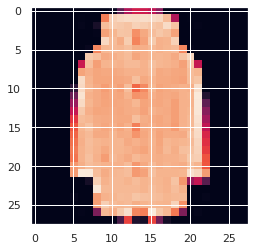

In [335]:
# predictions with hypermodel
plt.imshow(X_test_plot[rand_test_idx])
prediction = hypermodel.predict(X_test)
print("Prediction: ", np.argmax(prediction[rand_test_idx]))
print("Actual: ", y_test[rand_test_idx])

Prediction:  4
Actual:  4


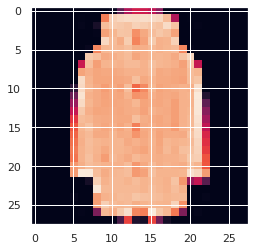

In [336]:
# predictions with loaded model
plt.imshow(X_test_plot[rand_test_idx])
prediction = model.predict(X_test)
print("Prediction: ", np.argmax(prediction[rand_test_idx]))
print("Actual: ", y_test[rand_test_idx])

In [337]:
# !rm -rf fm model